In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('vader_lexicon')

from transformers import pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner as kt

In [3]:
root_dir = "enron_email_data"  # Change this to your data directory
folders = ["enron1", "enron2", "enron3", "enron4", "enron5", "enron6"]

def load_data(folders, root_dir):
    data = []
    for folder in folders:
        ham_path = os.path.join(root_dir, folder, "ham")
        if os.path.exists(ham_path):
            for filename in os.listdir(ham_path):
                if filename.endswith(".txt"):
                    file_path = os.path.join(ham_path, filename)
                    with open(file_path, 'r', encoding='latin-1') as f:
                        text = f.read()
                        data.append((text, "ham"))
    return pd.DataFrame(data, columns=["text", "label"])

df = load_data(folders, root_dir)

stop_words = set(stopwords.words('english'))
custom_remove = {"fax", "mobile", "subject", "from", "to", "cc", "sent"}

def clean_text(text):
    lines = text.split('\n')
    header_patterns = ['subject:', 'from:', 'to:', 'cc:', 'sent:']
    filtered_lines = [line for line in lines if not any(line.strip().lower().startswith(pattern) for pattern in header_patterns)]
    text = ' '.join(filtered_lines)
    text = re.sub(r'\(\s*\d+\s*\)', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords and custom words
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and t not in custom_remove]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)
df = df[df["clean_text"].str.strip() != ""]

Sample TF-IDF Features:
    aa   ab  abb  abel  ability  able  absence  absolutely  abstract   ac  \
0  0.0  0.0  0.0   0.0      0.0   0.0      0.0         0.0       0.0  0.0   
1  0.0  0.0  0.0   0.0      0.0   0.0      0.0         0.0       0.0  0.0   
2  0.0  0.0  0.0   0.0      0.0   0.0      0.0         0.0       0.0  0.0   
3  0.0  0.0  0.0   0.0      0.0   0.0      0.0         0.0       0.0  0.0   
4  0.0  0.0  0.0   0.0      0.0   0.0      0.0         0.0       0.0  0.0   

   ...  york  young   yr  yvette  zero  zhiyong  zimin  zipper  zone  zufferli  
0  ...   0.0    0.0  0.0     0.0   0.0      0.0    0.0     0.0   0.0       0.0  
1  ...   0.0    0.0  0.0     0.0   0.0      0.0    0.0     0.0   0.0       0.0  
2  ...   0.0    0.0  0.0     0.0   0.0      0.0    0.0     0.0   0.0       0.0  
3  ...   0.0    0.0  0.0     0.0   0.0      0.0    0.0     0.0   0.0       0.0  
4  ...   0.0    0.0  0.0     0.0   0.0      0.0    0.0     0.0   0.0       0.0  

[5 rows x 5000 columns]


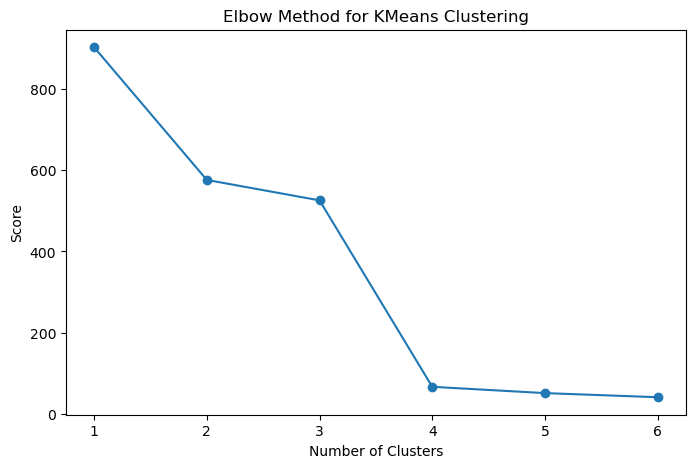

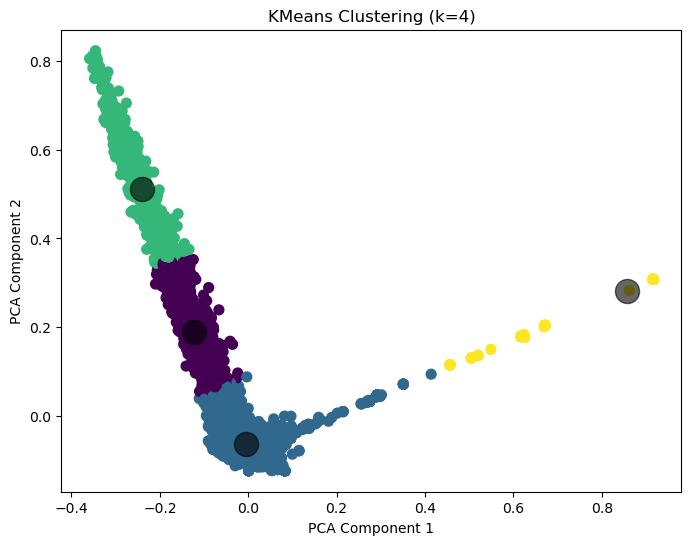

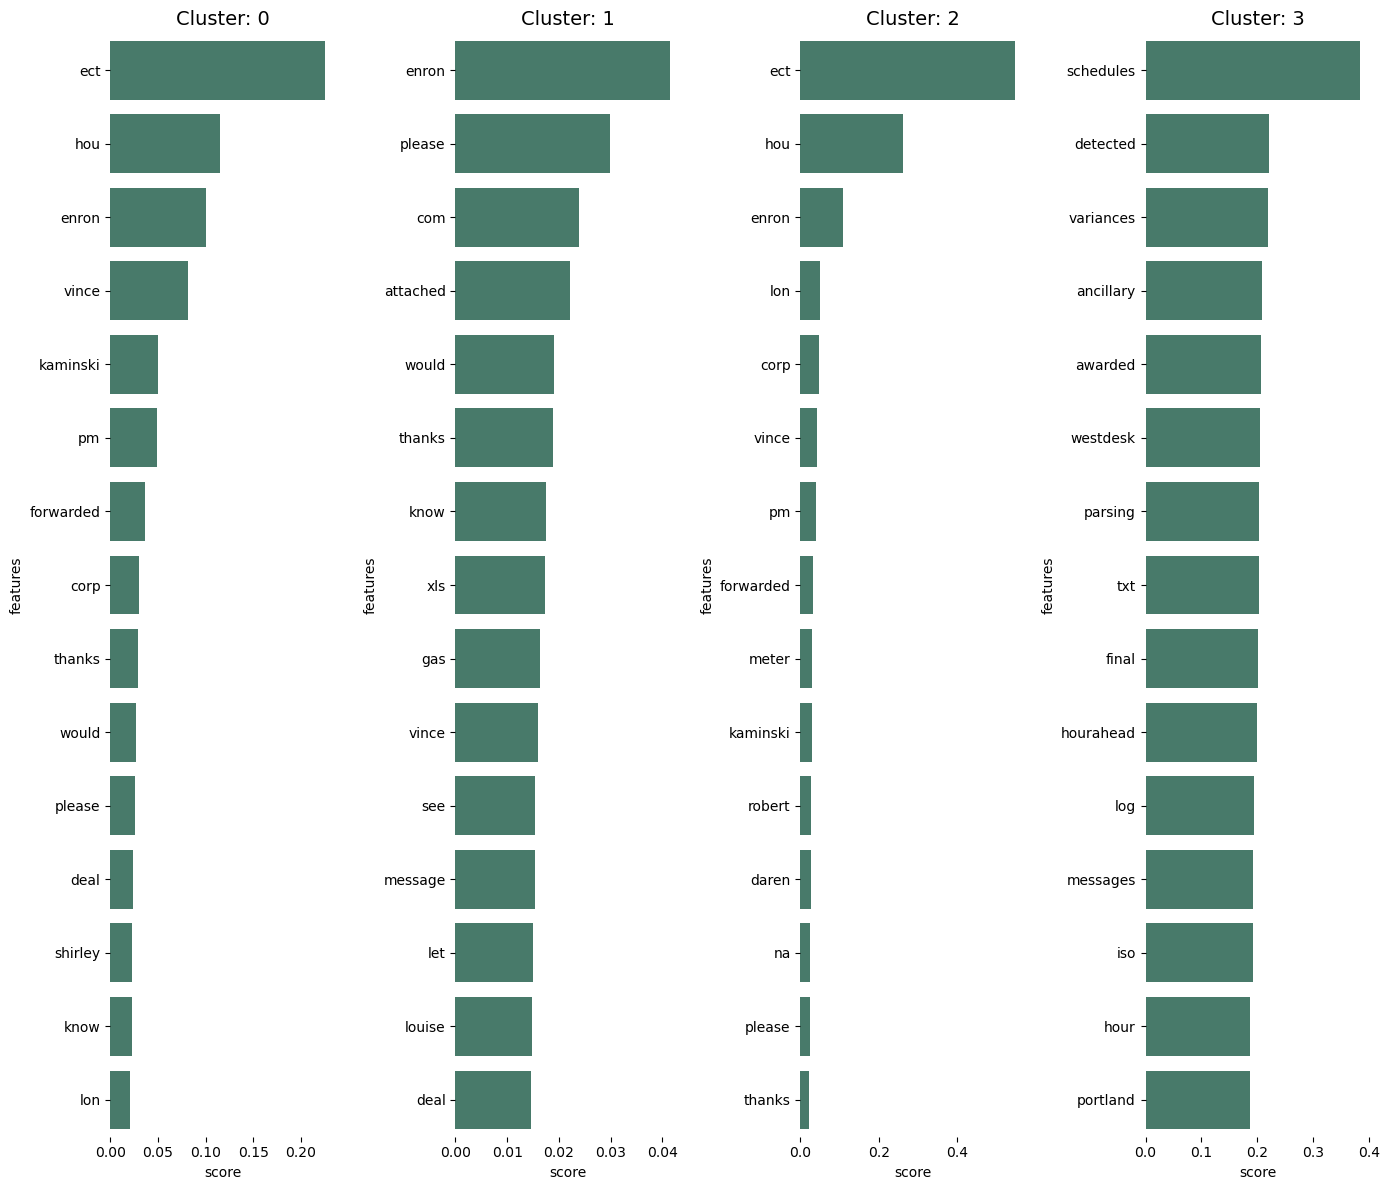

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords.words('english')), max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])
tfidf_norm = normalize(tfidf)
tfidf_array = tfidf_norm.toarray()

features_df = pd.DataFrame(tfidf_array, columns=tfidf_vectorizer.get_feature_names_out())
print("Sample TF-IDF Features:")
print(features_df.head())

sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(tfidf_array)

number_clusters = range(1, 7)
kmeans_list = [KMeans(n_clusters=i, max_iter=600, random_state=42) for i in number_clusters]
scores = [-k.fit(Y_sklearn).score(Y_sklearn) for k in kmeans_list]

plt.figure(figsize=(8, 5))
plt.plot(number_clusters, scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=600, random_state=42)
fitted = kmeans_model.fit(Y_sklearn)
predictions = kmeans_model.predict(Y_sklearn)

plt.figure(figsize=(8, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predictions, s=50, cmap='viridis')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering (k=4)')
plt.show()

def get_top_features_cluster(tfidf_array, prediction, n_feats):
    dfs = []
    for label in np.unique(prediction):
        indices = np.where(prediction == label)
        mean_scores = np.mean(tfidf_array[indices], axis=0)
        top_indices = np.argsort(mean_scores)[::-1][:n_feats]
        features = tfidf_vectorizer.get_feature_names_out()
        best_features = [(features[i], mean_scores[i]) for i in top_indices]
        dfs.append(pd.DataFrame(best_features, columns=['features', 'score']))
    return dfs

dfs = get_top_features_cluster(tfidf_array, predictions, 20)

def plot_features(dfs):
    fig = plt.figure(figsize=(14, 12))
    for i, df_cluster in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: " + str(i), fontsize=14)
        sns.barplot(x='score', y='features', data=df_cluster.head(15), ax=ax, color='#40826d')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.tick_params(axis='both', which='both', labelsize=10)
    plt.tight_layout()
    plt.show()

plot_features(dfs)

In [26]:
'''
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment_and_score(text):
    score = sia.polarity_scores(text)
    compound = score['compound']
    label = "positive" if compound >= 0.05 else "negative" if compound <= -0.05 else "neutral"
    return pd.Series([label, compound])

def get_bart_sentiment_and_score(text):
    # Initialize BART zero-shot classifier
    bart_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    candidate_labels = ["negative", "neutral", "positive"]
    result = bart_classifier(text, candidate_labels=candidate_labels)
    max_index = np.argmax(result["scores"])
    return pd.Series([result["labels"][max_index], result["scores"][max_index]])

# Apply sentiment functions to the cleaned text
df[['vader_sentiment', 'vader_score']] = df["clean_text"].apply(get_vader_sentiment_and_score)
df[['bart_sentiment', 'bart_score']] = df["clean_text"].apply(get_bart_sentiment_and_score)

# Save results to CSV
df.to_csv("email_sentiment_results.csv", index=False)
'''

'\nsia = SentimentIntensityAnalyzer()\n\ndef get_vader_sentiment_and_score(text):\n    score = sia.polarity_scores(text)\n    compound = score[\'compound\']\n    label = "positive" if compound >= 0.05 else "negative" if compound <= -0.05 else "neutral"\n    return pd.Series([label, compound])\n\ndef get_bart_sentiment_and_score(text):\n    # Initialize BART zero-shot classifier\n    bart_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")\n    candidate_labels = ["negative", "neutral", "positive"]\n    result = bart_classifier(text, candidate_labels=candidate_labels)\n    max_index = np.argmax(result["scores"])\n    return pd.Series([result["labels"][max_index], result["scores"][max_index]])\n\n# Apply sentiment functions to the cleaned text\ndf[[\'vader_sentiment\', \'vader_score\']] = df["clean_text"].apply(get_vader_sentiment_and_score)\ndf[[\'bart_sentiment\', \'bart_score\']] = df["clean_text"].apply(get_bart_sentiment_and_score)\n\n# Save results t

In [27]:
data = pd.read_csv("/Users/matthewray/email_sentiment_results.csv")
vader_labels = data["vader_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2}).values
bart_labels = data["bart_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2}).values

max_vocab = 5000
max_length = 200
keras_tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(data["clean_text"])
sequences = keras_tokenizer.texts_to_sequences(data["clean_text"])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

num_classes = 3
labels_cat_vader = to_categorical(vader_labels, num_classes=num_classes)
labels_cat_bart = to_categorical(bart_labels, num_classes=num_classes)

X_train_text_vader, X_test_text_vader, y_train_vader, y_test_vader = train_test_split(
    padded_sequences, labels_cat_vader, test_size=0.2, random_state=42, stratify=vader_labels
)
X_train_text_bart, X_test_text_bart, y_train_bart, y_test_bart = train_test_split(
    padded_sequences, labels_cat_bart, test_size=0.2, random_state=42, stratify=bart_labels
)

In [19]:
def build_bilstm_model(hp):
    model = Sequential()
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_length))
    
    embedding_dropout = hp.Float('embedding_dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(embedding_dropout))
    
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='LOG')
    model.add(Bidirectional(LSTM(lstm_units, kernel_regularizer=regularizers.l2(l2_reg))))
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))
    
    dense_l2 = hp.Float('dense_l2', min_value=0.0001, max_value=0.01, sampling='LOG')
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(dense_l2)))
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

tuner = kt.RandomSearch(
    build_bilstm_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='bilstm_tuning_run_from_scratch'
)

tuner.search(X_train_text_vader, y_train_vader,
             epochs=10,
             validation_split=0.2,
             callbacks=[early_stop])

best_hps = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters from new tuning run:")
print(f"Embedding Dim: {best_hps.get('embedding_dim')}")
print(f"Embedding Dropout: {best_hps.get('embedding_dropout')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"L2 Reg (LSTM): {best_hps.get('l2_reg')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Dense L2: {best_hps.get('dense_l2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

final_model_vader = tuner.hypermodel.build(best_hps)
final_model_bart = tuner.hypermodel.build(best_hps)


history_vader = final_model_vader.fit(
    X_train_text_vader, 
    y_train_vader,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

history_bart = final_model_bart.fit(
    X_train_text_bart, 
    y_train_bart,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

eval_vader = final_model_vader.evaluate(X_test_text_vader, y_test_vader, verbose=0)
eval_bart = final_model_bart.evaluate(X_test_text_bart, y_test_bart, verbose=0)

print("VADER-based Model Evaluation:", eval_vader)
print("BART-based Model Evaluation:", eval_bart)

Trial 10 Complete [00h 03m 52s]
val_accuracy: 0.9306292533874512

Best val_accuracy So Far: 0.9340409636497498
Total elapsed time: 00h 30m 54s
Best Hyperparameters from new tuning run:
Embedding Dim: 64
Embedding Dropout: 0.4
LSTM Units: 32
L2 Reg (LSTM): 0.00011551879589796051
Dropout Rate: 0.6000000000000001
Dense L2: 0.0015916565411355722
Learning Rate: 0.006184222375640603
Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8753 - loss: 0.4341  
Epoch 1: val_loss improved from inf to 0.29208, saving model to best_model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.8754 - loss: 0.4339 - val_accuracy: 0.9196 - val_loss: 0.2921
Epoch 2/20
329/330 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9385 - loss: 0.2361 
Epoch 2: val_loss improved from 0.29208 to 0.27460, saving model to best_model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9385 - loss: 0.2361 - val_accuracy: 0.9306 - val_loss: 0.2746
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s

In [21]:
cv_scores_vader = []
y_train_vader_integers = np.argmax(y_train_vader, axis=1)
skf_vader = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in skf_vader.split(X_train_text_vader, y_train_vader_integers):
    print(f"\nTraining VADER fold {fold}...")
    X_train_fold, X_val_fold = X_train_text_vader[train_idx], X_train_text_vader[val_idx]
    y_train_fold, y_val_fold = y_train_vader[train_idx], y_train_vader[val_idx]
    
    model_cv_vader = tuner.hypermodel.build(best_hps)
    history_cv_vader = model_cv_vader.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=20,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    
    loss_cv, acc_cv = model_cv_vader.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} VADER Validation Accuracy: {acc_cv:.4f}")
    cv_scores_vader.append(acc_cv)
    fold += 1

print("\nMean Cross-Validation Accuracy (VADER-based):", np.mean(cv_scores_vader))


cv_scores_bart = []
y_train_bart_integers = np.argmax(y_train_bart, axis=1)
skf_bart = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in skf_bart.split(X_train_text_bart, y_train_bart_integers):
    print(f"\nTraining BART fold {fold}...")
    X_train_fold, X_val_fold = X_train_text_bart[train_idx], X_train_text_bart[val_idx]
    y_train_fold, y_val_fold = y_train_bart[train_idx], y_train_bart[val_idx]
    
    model_cv_bart = tuner.hypermodel.build(best_hps)
    history_cv_bart = model_cv_bart.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=20,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    
    loss_cv, acc_cv = model_cv_bart.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} BART Validation Accuracy: {acc_cv:.4f}")
    cv_scores_bart.append(acc_cv)
    fold += 1

print("\nMean Cross-Validation Accuracy (BART-based):", np.mean(cv_scores_bart))


Training VADER fold 1...
Epoch 1/20


/Users/matthewray/miniconda3/envs/nlp_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


330/330 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8775 - loss: 0.4316 - val_accuracy: 0.9234 - val_loss: 0.2712
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9405 - loss: 0.2370 - val_accuracy: 0.9272 - val_loss: 0.2690
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9527 - loss: 0.1795 - val_accuracy: 0.9340 - val_loss: 0.2897
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9624 - loss: 0.1632 - val_accuracy: 0.9276 - val_loss: 0.2876
Fold 1 VADER Validation Accuracy: 0.9272

Training VADER fold 2...
Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 105s 317ms/step - accuracy: 0.8757 - loss: 0.4469 - val_accuracy: 0.9280 - val_loss: 0.2889
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9371 - loss: 0.2448 - val_accuracy: 0.9280 - val_loss: 0.2777
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9551 - loss: 0.1693 - val_accuracy: 0.9246 - val_loss: 0.2772
Epoch 4/20
330/330 ━━━━━━━━━━━━━

/Users/matthewray/miniconda3/envs/nlp_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


330/330 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6342 - loss: 0.8049 - val_accuracy: 0.7293 - val_loss: 0.6456
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7882 - loss: 0.5819 - val_accuracy: 0.7669 - val_loss: 0.5936
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8428 - loss: 0.4599 - val_accuracy: 0.7570 - val_loss: 0.6812
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.8721 - loss: 0.4045 - val_accuracy: 0.7638 - val_loss: 0.6394
Fold 1 BART Validation Accuracy: 0.7669

Training BART fold 2...
Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.6501 - loss: 0.8034 - val_accuracy: 0.7157 - val_loss: 0.6427
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.7751 - loss: 0.5816 - val_accuracy: 0.7597 - val_loss: 0.5985
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.8229 - loss: 0.4945 - val_accuracy: 0.7665 - val_loss: 0.6235
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━

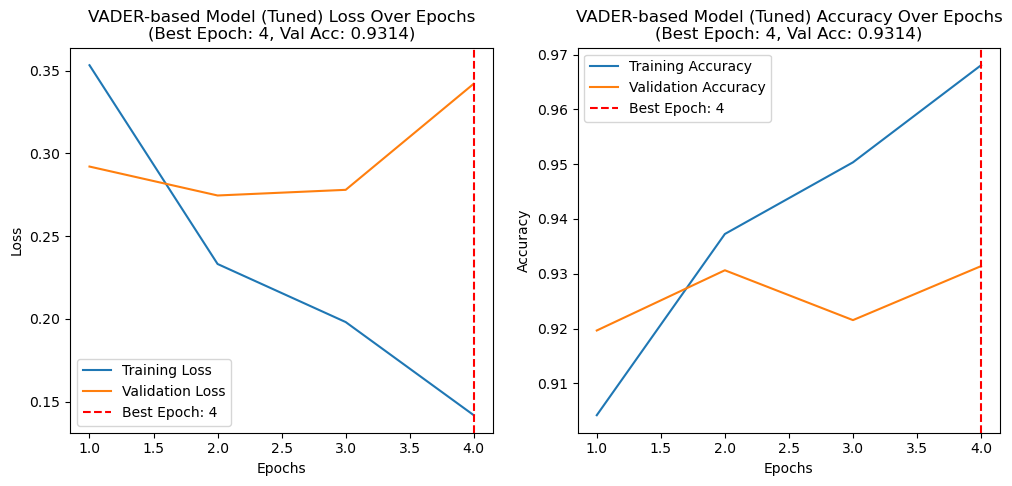

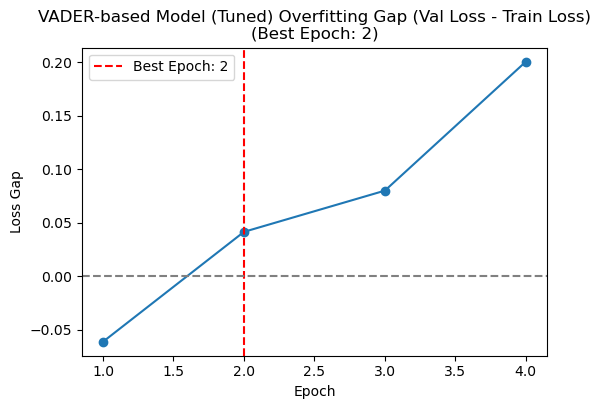

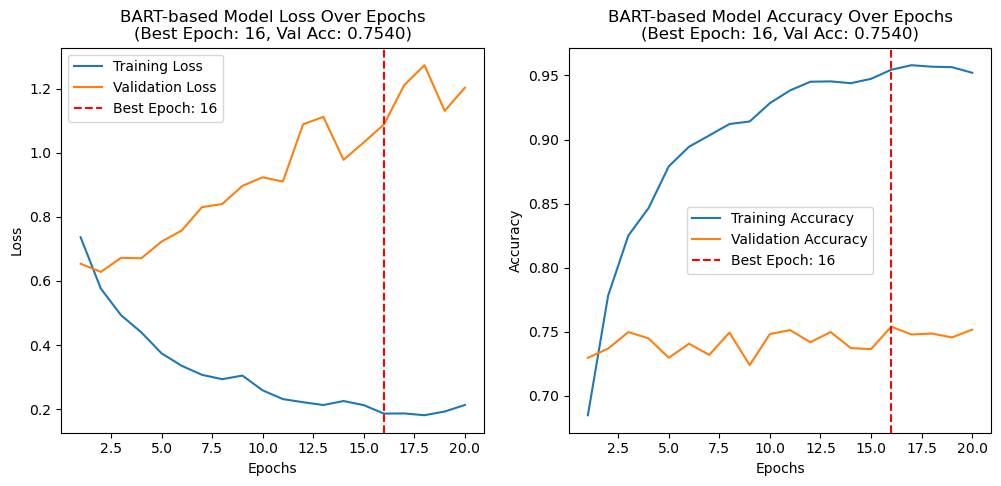

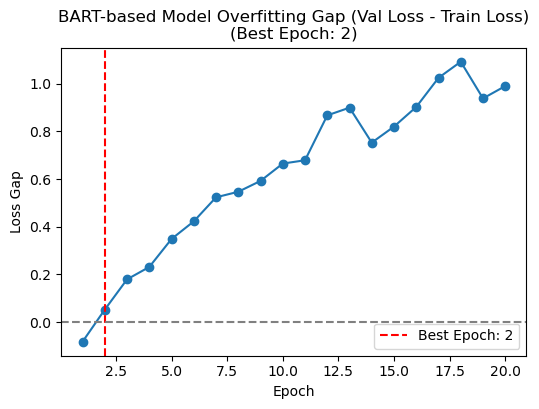


VADER-based Model:
 Best Epoch: 4
 Training Accuracy at Best Epoch: 0.9681
 Training Loss at Best Epoch: 0.1418
 Test Accuracy: 0.9293
 Test Loss: 0.2810
--------------------------------------------------
BART-based Model:
 Best Epoch: 16
 Training Accuracy at Best Epoch: 0.9545
 Training Loss at Best Epoch: 0.1858
 Test Accuracy: 0.7395
 Test Loss: 1.2324


In [28]:
def plot_history(history, title_prefix="Model"):
    epochs = range(1, len(history.history['loss']) + 1)
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title(f"{title_prefix} Loss Over Epochs\n(Best Epoch: {best_epoch}, Val Acc: {best_val_acc:.4f})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title(f"{title_prefix} Accuracy Over Epochs\n(Best Epoch: {best_epoch}, Val Acc: {best_val_acc:.4f})")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

def plot_overfitting_gap(history, title_prefix="Model"):
    loss_gap = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    epochs = range(1, len(loss_gap) + 1)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss_gap, marker='o')
    plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title(f"{title_prefix} Overfitting Gap (Val Loss - Train Loss)\n(Best Epoch: {best_epoch})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss Gap')
    plt.legend()
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

plot_history(history_vader, title_prefix="VADER-based Model (Tuned)")
plot_overfitting_gap(history_vader, title_prefix="VADER-based Model (Tuned)")

plot_history(history_bart, title_prefix="BART-based Model")
plot_overfitting_gap(history_bart, title_prefix="BART-based Model")

best_epoch_vader = np.argmax(history_vader.history['val_accuracy']) + 1
best_train_acc_vader = history_vader.history['accuracy'][best_epoch_vader - 1]
best_train_loss_vader = history_vader.history['loss'][best_epoch_vader - 1]
test_loss_vader, test_acc_vader = final_model_vader.evaluate(X_test_text_vader, y_test_vader, verbose=0)

print("\nVADER-based Model:")
print(f" Best Epoch: {best_epoch_vader}")
print(f" Training Accuracy at Best Epoch: {best_train_acc_vader:.4f}")
print(f" Training Loss at Best Epoch: {best_train_loss_vader:.4f}")
print(f" Test Accuracy: {test_acc_vader:.4f}")
print(f" Test Loss: {test_loss_vader:.4f}")
print("-" * 50)

# For BART-based model
best_epoch_bart = np.argmax(history_bart.history['val_accuracy']) + 1
best_train_acc_bart = history_bart.history['accuracy'][best_epoch_bart - 1]
best_train_loss_bart = history_bart.history['loss'][best_epoch_bart - 1]
test_loss_bart, test_acc_bart = final_model_bart.evaluate(X_test_text_bart, y_test_bart, verbose=0)

print("BART-based Model:")
print(f" Best Epoch: {best_epoch_bart}")
print(f" Training Accuracy at Best Epoch: {best_train_acc_bart:.4f}")
print(f" Training Loss at Best Epoch: {best_train_loss_bart:.4f}")
print(f" Test Accuracy: {test_acc_bart:.4f}")
print(f" Test Loss: {test_loss_bart:.4f}")
